In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-dataset-ford-and-mercedes/vw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/bmw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/merc.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/hyundi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vauxhall.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/skoda.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean focus.csv


# 1. Data Preparation

## Load Data

In [2]:
df = pd.read_csv('../input/used-car-dataset-ford-and-mercedes/bmw.csv')
print(df.shape)
df.head()

(10781, 9)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [3]:
#pd.to_datetime('today').year - df.year

## Create new column "age"

In [4]:
now = datetime.datetime.now().year
df['age'] = now - df['year']

## drop column to avoid Multicollinearity

In [5]:
df.drop(columns = ['year'], inplace = True)
df.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,5 Series,11200,Automatic,67068,Diesel,125,57.6,2.0,6
1,6 Series,27000,Automatic,14827,Petrol,145,42.8,2.0,2
2,5 Series,16000,Automatic,62794,Diesel,160,51.4,3.0,4
3,1 Series,12750,Automatic,26676,Diesel,145,72.4,1.5,3
4,7 Series,14500,Automatic,39554,Diesel,160,50.4,3.0,6


In [6]:
#df['target_price'] = np.log(df['price'])
#df.head()

# 2. Exporatory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   price         10781 non-null  int64  
 2   transmission  10781 non-null  object 
 3   mileage       10781 non-null  int64  
 4   fuelType      10781 non-null  object 
 5   tax           10781 non-null  int64  
 6   mpg           10781 non-null  float64
 7   engineSize    10781 non-null  float64
 8   age           10781 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


**No Missing Value**

In [8]:
df.isnull().any()

model           False
price           False
transmission    False
mileage         False
fuelType        False
tax             False
mpg             False
engineSize      False
age             False
dtype: bool

In [9]:
for col in df.columns[0:]:
    print(col, ': ', len(df[col].unique()), ' lebels')

model :  24  lebels
price :  3777  lebels
transmission :  3  lebels
mileage :  8086  lebels
fuelType :  5  lebels
tax :  38  lebels
mpg :  102  lebels
engineSize :  17  lebels
age :  25  lebels


In [10]:
#df.select_dtypes(exclude=['object'])

# **Category features**

In [11]:
#df_cate = df.select_dtypes(include=['object']).columns.values.tolist()
df_cate = df.select_dtypes(include=['object'])
df_cate.sample(10)

,model,transmission,fuelType
5508,M4,Automatic,Petrol
3429,3 Series,Semi-Auto,Petrol
8803,3 Series,Automatic,Petrol
2016,4 Series,Semi-Auto,Petrol
9858,X5,Automatic,Diesel
7534,3 Series,Automatic,Diesel
1408,4 Series,Automatic,Diesel
5023,4 Series,Automatic,Diesel
1889,3 Series,Semi-Auto,Petrol
1114,X1,Semi-Auto,Diesel


In [12]:
df_cate.apply(lambda x: x.nunique(), axis=0)

model           24
transmission     3
fuelType         5
dtype: int64

# **Numerical features**

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,10781.0,22733.408867,11415.528189,1200.0,14950.0,20462.0,27940.0,123456.0
mileage,10781.0,25496.986550,25143.192559,1.0,5529.0,18347.0,38206.0,214000.0
tax,10781.0,131.702068,61.510755,0.0,135.0,145.0,145.0,580.0
mpg,10781.0,56.399035,31.336958,5.5,45.6,53.3,62.8,470.8
engineSize,10781.0,2.167767,0.552054,0.0,2.0,2.0,2.0,6.6
age,10781.0,2.921065,2.349038,0.0,1.0,3.0,4.0,24.0


In [14]:
#df_dummies.describe().T

In [15]:
#df[(df['engineSize']==0) & (df['tax']==0)]

In [16]:
#pd.crosstab(df.model,df.engineSize, margins= True)

In [17]:
#df.notnull().sum()

# Check correlation

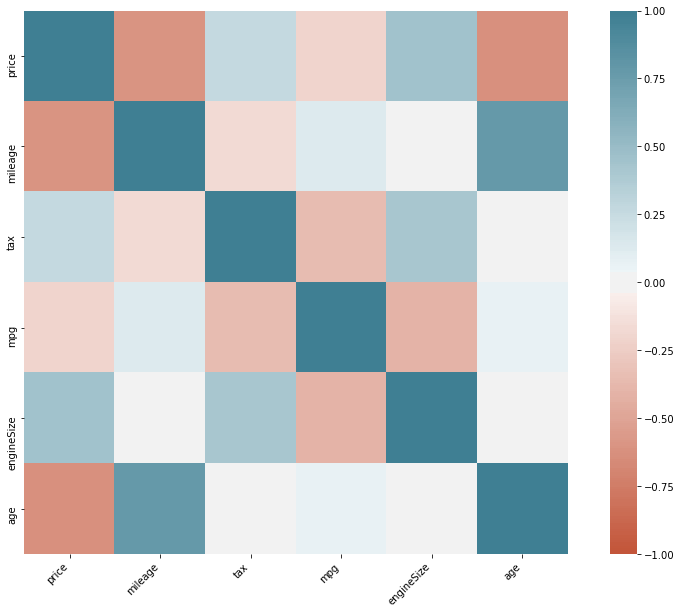

In [18]:
plt.subplots(figsize=(15,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## from correlation we would focus to age, engine size and mileage. 

In [19]:
#sns.pairplot(df);

In [20]:
#fig, ax = plt.subplots(figsize=(16,6))
#sns.boxplot(ax=ax, x="fuelType", y="price", hue="transmission", data=df);
#sns.boxplot(ax=ax, x="transmission", y="price", hue="fuelType", data=df);

## Consider to object variable which is model, transimission and fuelType

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


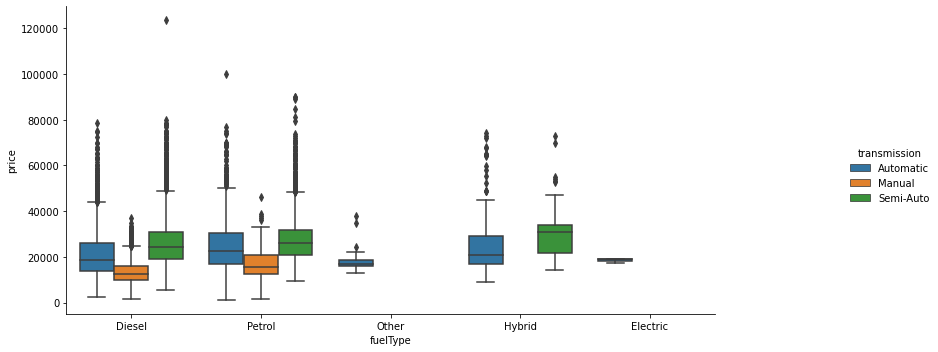

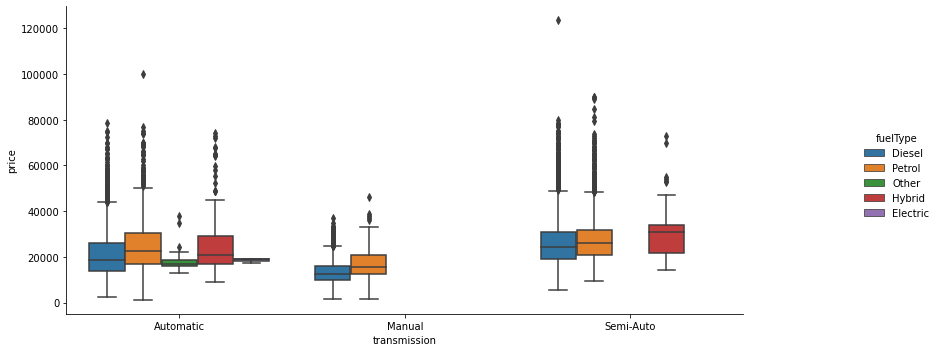

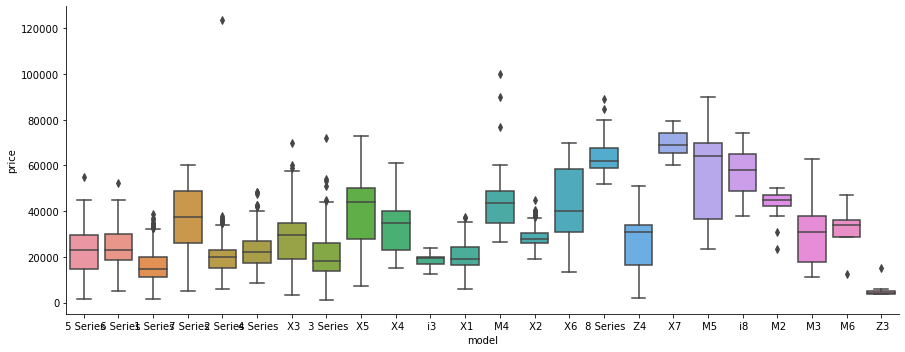

In [21]:
#fig, ax = plt.subplots(figsize=(16,6))
#plt.figure(figsize=(16,6))
g1 = sns.catplot(ax=ax, x="fuelType", y="price", hue="transmission", kind="box", data=df);
g1.fig.set_figwidth(15);
g1.fig.set_figheight(5);
g2 = sns.catplot(ax=ax, x="transmission", y="price", hue="fuelType", kind="box", data=df);
g2.fig.set_figwidth(15);
g2.fig.set_figheight(5);
g3 = sns.catplot(ax=ax, x="model", y="price", kind="box", data=df);
g3.fig.set_figwidth(15);
g3.fig.set_figheight(5);

## Manual and Diesel trend to have lower price

# **Select price range for model**

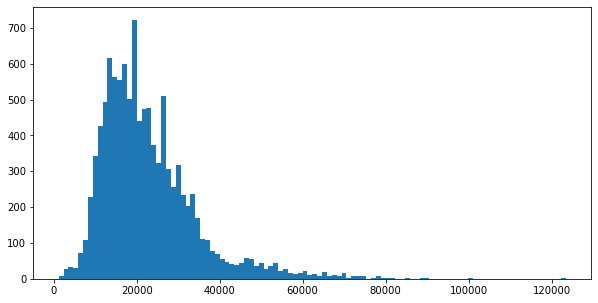

used car price has value between 1,200 and 123,456
(10781, 9)


In [22]:
plt.figure(figsize=(10, 5))
plt.hist(df['price'], bins='auto')
plt.show()
print("used car price has value between {:,} and {:,}".format(df['price'].min(),df['price'].max()))
print(df.shape)

## Scope price for prediction between 3SD for precision model

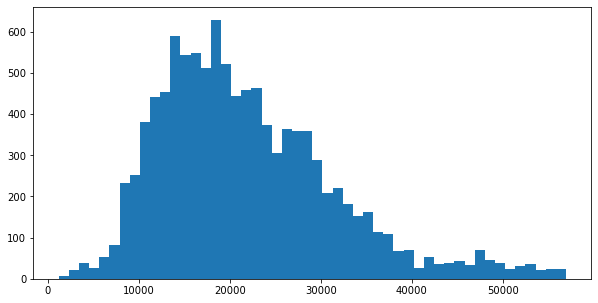

used car price has value between 1,200 and 56,950
(10580, 9)


In [23]:
z_score = stats.zscore(df['price'])
#np.abs(z_score)
#plt.figure(figsize=(10, 5))
#plt.hist(np.abs(z_score), bins='auto')
#plt.show()

df = df[np.abs(z_score) < 3]
plt.figure(figsize=(10, 5))
plt.hist(df['price'], bins='auto')
plt.show()
print("used car price has value between {:,} and {:,}".format(df['price'].min(),df['price'].max()))
print(df.shape)

## for price we consider to use log to normalize the price scale to predict

# 3. Model Seletion

In [24]:
X = df.drop(columns=['price'])
y = df.price

In [25]:
X.head()

,model,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,5 Series,Automatic,67068,Diesel,125,57.6,2.0,6
1,6 Series,Automatic,14827,Petrol,145,42.8,2.0,2
2,5 Series,Automatic,62794,Diesel,160,51.4,3.0,4
3,1 Series,Automatic,26676,Diesel,145,72.4,1.5,3
4,7 Series,Automatic,39554,Diesel,160,50.4,3.0,6


In [26]:
y.head()

0    11200
1    27000
2    16000
3    12750
4    14500
Name: price, dtype: int64

# Get dummies

In [27]:
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)
X.head()

,mileage,tax,mpg,engineSize,age,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,model_ Z3,model_ Z4,model_ i3,model_ i8,transmission_Manual,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,67068,125,57.6,2.0,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,14827,145,42.8,2.0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,62794,160,51.4,3.0,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,26676,145,72.4,1.5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,39554,160,50.4,3.0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Fit Model and Cross Validation Score

## Using Linear Regression Model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
reg = LinearRegression().fit(X, y)

print('Linear Regression Score: {}'.format(cross_val_score(reg, X, y, cv=30).mean()))

Linear Regression Score: 0.8071258131543612


In [29]:
y_predicted = reg.predict(X_test)

accuracy_test = cross_val_score(reg, X_test, y_test, cv=30)
print('Test_model_score = ', accuracy_test.mean())

Test_model_score =  0.8591911122406153


In [30]:
y_predicted

array([ 9928.49070385, 22471.40222368, 21682.43022034, ...,
       21758.32197043, 20737.59340663, 14082.44711352])

In [31]:
pd.Series(y_predicted, name='price_predict')

0        9928.490704
1       22471.402224
2       21682.430220
3       25406.902345
4       -4840.961220
            ...     
3169    17443.434230
3170    34081.574241
3171    21758.321970
3172    20737.593407
3173    14082.447114
Name: price_predict, Length: 3174, dtype: float64

In [32]:
d_test = pd.concat([y_test.reset_index(drop=True),pd.Series(y_predicted, name='price_predict')], axis='columns' )
d_test

,price,price_predict
0,10499,9928.490704
1,20875,22471.402224
2,19880,21682.430220
3,24450,25406.902345
4,2375,-4840.961220
...,...,...
3169,14500,17443.434230
3170,30998,34081.574241
3171,14998,21758.321970
3172,25450,20737.593407


In [33]:
d_test.corr(method ='pearson') 

,price,price_predict
price,1.000000,0.930493
price_predict,0.930493,1.000000


# END

In [34]:
print('--'*120)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Applying to Multiple Files

So far, you've one-hot-encoded your training data. What about when you have multiple files (e.g. a test dataset, or some other data that you'd like to make predictions for)? Scikit-learn is sensitive to the ordering of columns, so if the training dataset and test datasets get misaligned, your results will be nonsense. This could happen if a categorical had a different number of values in the training data vs the test data.

Ensure the test data is encoded in the same manner as the training data with the align command:

In [35]:
#X_train_d = pd.get_dummies(X_train, columns= ['model', 'transmission', 'fuelType'], drop_first = True)
#X_test_d = pd.get_dummies(X_test, columns= ['model', 'transmission', 'fuelType'], drop_first = True)

In [36]:
train.select_dtypes(include=['object'])

NameError: name 'train' is not defined

In [37]:
ohe_training = pd.get_dummies(ohe_training[train.select_dtypes(include=['object'])])
ohe_training

NameError: name 'ohe_training' is not defined

In [38]:
ohe_training = pd.get_dummies(train)
ohe_test = pd.get_dummies(test)

final_train, final_test = ohe_training.align(ohe_test, join='left', axis=1)

NameError: name 'train' is not defined

In [39]:
final_test.isnull().any()

NameError: name 'final_test' is not defined

The align command makes sure the columns show up in the same order in both datasets (it uses column names to identify which columns line up in each dataset.) The argument join='left' specifies that we will do the equivalent of SQL's left join. That means, if there are ever columns that show up in one dataset and not the other, we will keep exactly the columns from our training data. The argument join='inner' would do what SQL databases call an inner join, keeping only the columns showing up in both datasets. That's also a sensible choice.

In [40]:
X_train_d = final_train.drop(['price'], axis=1)
y_train_d = final_train['price']

X_test_d = final_test.drop(['price'], axis=1)
y_test_d = final_test['price']

NameError: name 'final_train' is not defined

In [41]:
X_test_d.isnull().any()

NameError: name 'X_test_d' is not defined

In [42]:
model = LinearRegression()
model.fit(X_train_d, y_train_d)

accuracy = cross_val_score(model, X_train_d, y_train_d, cv=30)
print('train_model_score = ', accuracy.mean())

NameError: name 'X_train_d' is not defined

In [43]:
y_predicted = model.predict(X_test_d)

accuracy_test = cross_val_score(model, X_test_d, y_test_d, cv=30)
print('test_model_score = ', accuracy_test.mean())

NameError: name 'X_test_d' is not defined

In [44]:
X_test_d.isnull().any()

NameError: name 'X_test_d' is not defined

In [45]:
X_test_d['model_ M5']

NameError: name 'X_test_d' is not defined

In [46]:
y_predicted

array([ 9928.49070385, 22471.40222368, 21682.43022034, ...,
       21758.32197043, 20737.59340663, 14082.44711352])

In [47]:
pd.Series(y_predicted, name='price_predict')

0        9928.490704
1       22471.402224
2       21682.430220
3       25406.902345
4       -4840.961220
            ...     
3169    17443.434230
3170    34081.574241
3171    21758.321970
3172    20737.593407
3173    14082.447114
Name: price_predict, Length: 3174, dtype: float64

In [48]:
d_test = pd.concat([y_test_d.reset_index(drop=True),pd.Series(y_predicted, name='price_predict')], axis='columns' )
d_test

NameError: name 'y_test_d' is not defined

In [49]:
corrr = corr(d_test.price, d_test.price_predict)

TypeError: 'DataFrame' object is not callable

In [50]:
#fig, ax = plt.subplots(figsize=(16,10))
#ax.plot(df_dummies['price'], '--')
#ax.set_xlabel('--')
#ax.set_ylabel('price')

In [51]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df, title="BMW Used Car Profiling Report")

In [52]:
#df.profile_report()

In [53]:
#profile.to_widgets()

In [54]:
#profile.to_notebook_iframe()

In [55]:
#df.loc[df.fuelType=='Hybrid'].shape